#

# Scraping TOP_250 Movie Data From IMDB

In [3]:
import requests 
from bs4 import BeautifulSoup
import pandas as pd
import time

In [4]:

BASE_URL = "https://www.imdb.com/chart/top/"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)",
    "Accept-Language": "en-US,en;q=0.9"
}

movie_names, ratings, years, votes, runtimes,budgets,collections= [], [], [], [], [],[],[]

for start in range(1, 251, 25):  # 1 → 250
    url = f"{BASE_URL}?start={start}"
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")

    movies = soup.select("li.ipc-metadata-list-summary-item")

    for movie in movies:
        movie_names.append(
            movie.select_one("h3.ipc-title__text").get_text(strip=True)
        )

        ratings.append(
            movie.find("span",class_="ipc-rating-star--rating").get_text(strip=True)
        )

        years.append(
            movie.select_one(".cli-title-metadata-item").get_text(strip=True)
        )

        votes.append(
            movie.select_one('[data-testid="ratingGroup--imdb-rating"] span.ipc-rating-star--voteCount')
            .get_text(strip=True)
        )

        runtime = movie.find("span", string=lambda x: x and ("h" in x or "m" in x))
        runtimes.append(runtime.get_text(strip=True) if runtime else "N/A")
        
         


In [5]:
print(
    len(movie_names),
    len(ratings),
    len(years),
    len(votes),
    len(runtimes),
)

250 250 250 250 250


In [6]:
df= pd.DataFrame({
    "Movie_name": movie_names,
    "Rating": ratings,
    "Release_year": years,
    "Views": votes,
    "Runtime": runtimes,
})


In [7]:
df

,Movie_name,Rating,Release_year,Views,Runtime
0,The Shawshank Redemption,9.3,1994,(3.2M),2h 22m
1,The Godfather,9.2,1972,(2.2M),2h 55m
2,The Dark Knight,9.1,2008,(3.1M),2h 32m
3,The Godfather Part II,9.0,1974,(1.5M),3h 22m
4,12 Angry Men,9.0,1957,(973K),1h 36m
...,...,...,...,...,...
245,It's a Wonderful Life,8.6,1946,(551K),2h 10m
246,The Silence of the Lambs,8.6,1991,(1.7M),1h 58m
247,Seven Samurai,8.6,1954,(399K),3h 27m
248,Saving Private Ryan,8.6,1998,(1.6M),2h 49m


# Collecting budget and collections 

In [ ]:
for start in range(1, 251, 25):
    url = f"{BASE_URL}?start={start}"
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")

    movies = soup.find_all("li", class_="ipc-metadata-list-summary-item")

    for movie in movies:
        link = movie.find("a")["href"]
        movie_url = "https://www.imdb.com/" + link

        detail_response = requests.get(movie_url, headers=headers)
        detail_soup = BeautifulSoup(detail_response.text, "html.parser")

        budget_li = detail_soup.find("li", {"data-testid": "title-boxoffice-budget"})
        gross_li = detail_soup.find("li", {"data-testid": "title-boxoffice-cumulativeworldwidegross"})

        budget = budget_li.get_text(strip=True) if budget_li else "N/A"
        gross = gross_li.get_text(strip=True) if gross_li else "N/A"

        budgets.append(budget)
        collections.append(gross)

        time.sleep(0.5)  
    

In [ ]:
dff =pd.DataFrame({
    "Budget":budgets,
    "Collection":collections
})

In [ ]:
dff

# Concatenating the both dataframes  &  converting into csv file

In [ ]:
Dataset = pd.concat([df,dff],axis = 1)

In [ ]:
Dataset.to_csv("IDMB.csv",index=False)
df = pd.read_csv("IMDB.csv")

# Load TOP_250 MOVIES Data

In [13]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np

In [88]:
df = pd.read_csv("IMDB.csv")

In [89]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Movie_name    250 non-null    object 
 1   Rating        250 non-null    float64
 2   Release_year  250 non-null    int64  
 3   Views         250 non-null    object 
 4   Runtime       250 non-null    object 
 5   Budget        245 non-null    object 
 6   Collection    245 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 13.8+ KB


Movie_name      0
Rating          0
Release_year    0
Views           0
Runtime         0
Budget          5
Collection      5
dtype: int64

In [90]:
df.head()

,Movie_name,Rating,Release_year,Views,Runtime,Budget,Collection
0,The Shawshank Redemption,9.3,1994,(3.2M),2h 22m,"Budget$25,000,000 (estimated)","Gross worldwide$29,334,033"
1,The Godfather,9.2,1972,(2.2M),2h 55m,"Budget$25,000,000 (estimated)","Gross worldwide$29,334,033"
2,The Dark Knight,9.1,2008,(3.1M),2h 32m,"Budget$6,000,000 (estimated)","Gross worldwide$250,926,380"
3,The Godfather Part II,9.0,1974,(1.5M),3h 22m,"Budget$185,000,000 (estimated)","Gross worldwide$1,008,477,382"
4,12 Angry Men,9.0,1957,(972K),1h 36m,"Budget$13,000,000 (estimated)","Gross worldwide$48,204,606"


# Cleaning The Dataset

In [91]:
def clean_view(x):
    if pd.isna(x):
        return np.nan

    x = x.strip("()")

    if "M" in x:
        return float(x.replace("M", "")) * 1_000_000
    elif "K" in x:
        return float(x.replace("K", "")) * 1_000
    else:
        return float(x)

In [92]:
# claening Views data
df["Views"] = df["Views"].apply(clean_view)

In [93]:
def run_time(x):
    if pd.isna(x):
        return np.nan
    hours = minutes = 0
    if "h" in x:
        hour = int(x.split("h")[0])
        x = x.split("h")[1]
    if "m" in x:
        minutes = int(x.replace("m","").strip())
    return hour*60 +minutes
    

In [94]:
#Converting runtime values
df["Runtime"] = df["Runtime"].apply(run_time)

In [95]:
# Cleaning budget  Collections value and converting into float values

df["Budget"] = (df["Budget"].where(df["Budget"].notna())
    .astype(str)
    .str.replace("Budget$","",regex=False)
    .str.replace(",","",regex=False)
    .str.extract(r"(\d+)")
    .astype(float))

df["Collection"] = (df["Collection"].where(df["Collection"].notna())
    .astype(str)
    .str.replace("Gross worldwide$","",regex=False)
    .str.replace(",","",regex=False)
    .str.extract(r"(\d+)")
    .astype(float))


In [96]:
df.info()
df.isna().sum()
# df.drop_duplicates()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Movie_name    250 non-null    object 
 1   Rating        250 non-null    float64
 2   Release_year  250 non-null    int64  
 3   Views         250 non-null    float64
 4   Runtime       250 non-null    int64  
 5   Budget        245 non-null    float64
 6   Collection    245 non-null    float64
dtypes: float64(4), int64(2), object(1)
memory usage: 13.8+ KB


,Rating,Release_year,Views,Runtime,Budget,Collection
count,250.000000,250.000000,2.500000e+02,250.000000,2.450000e+02,2.450000e+02
mean,8.812000,1988.320000,1.856240e+06,157.120000,5.613110e+07,3.963153e+08
std,0.199034,17.761743,7.288757e+05,28.983197,5.453548e+07,3.601204e+08
min,8.600000,1946.000000,3.990000e+05,96.000000,3.500000e+05,9.844000e+03
25%,8.600000,1975.000000,1.500000e+06,136.000000,1.300000e+07,4.820461e+07
50%,8.800000,1994.000000,1.900000e+06,152.000000,3.300000e+07,2.868014e+08
75%,9.000000,1999.000000,2.400000e+06,178.000000,9.300000e+07,6.782265e+08
max,9.300000,2014.000000,3.200000e+06,207.000000,1.850000e+08,1.148738e+09


# Fill Missing values with appropiate values

In [97]:
from sklearn.impute import SimpleImputer

In [98]:
imputer = SimpleImputer(strategy="mean")
col = ["Budget","Collection"]
df[col] = imputer.fit_transform(df[col])

In [99]:
df.isna().sum()

Movie_name      0
Rating          0
Release_year    0
Views           0
Runtime         0
Budget          0
Collection      0
dtype: int64

In [100]:
df

,Movie_name,Rating,Release_year,Views,Runtime,Budget,Collection
0,The Shawshank Redemption,9.3,1994,3200000.0,142,2.500000e+07,2.933403e+07
1,The Godfather,9.2,1972,2200000.0,175,2.500000e+07,2.933403e+07
2,The Dark Knight,9.1,2008,3100000.0,152,6.000000e+06,2.509264e+08
3,The Godfather Part II,9.0,1974,1500000.0,202,1.850000e+08,1.008477e+09
4,12 Angry Men,9.0,1957,972000.0,96,1.300000e+07,4.820461e+07
...,...,...,...,...,...,...,...
245,It's a Wonderful Life,8.6,1946,551000.0,130,5.613110e+07,3.963153e+08
246,The Silence of the Lambs,8.6,1991,1700000.0,118,5.613110e+07,3.963153e+08
247,Seven Samurai,8.6,1954,399000.0,207,5.613110e+07,3.963153e+08
248,Saving Private Ryan,8.6,1998,1600000.0,169,5.613110e+07,3.963153e+08


# EDA

In [101]:
df.describe()

,Rating,Release_year,Views,Runtime,Budget,Collection
count,250.000000,250.000000,2.500000e+02,250.000000,2.500000e+02,2.500000e+02
mean,8.812000,1988.320000,1.856240e+06,157.120000,5.613110e+07,3.963153e+08
std,0.199034,17.761743,7.288757e+05,28.983197,5.398516e+07,3.564864e+08
min,8.600000,1946.000000,3.990000e+05,96.000000,3.500000e+05,9.844000e+03
25%,8.600000,1975.000000,1.500000e+06,136.000000,1.300000e+07,4.820461e+07
50%,8.800000,1994.000000,1.900000e+06,152.000000,3.300000e+07,2.868014e+08
75%,9.000000,1999.000000,2.400000e+06,178.000000,9.300000e+07,6.782265e+08
max,9.300000,2014.000000,3.200000e+06,207.000000,1.850000e+08,1.148738e+09


<Axes: xlabel='Release_year', ylabel='Count'>

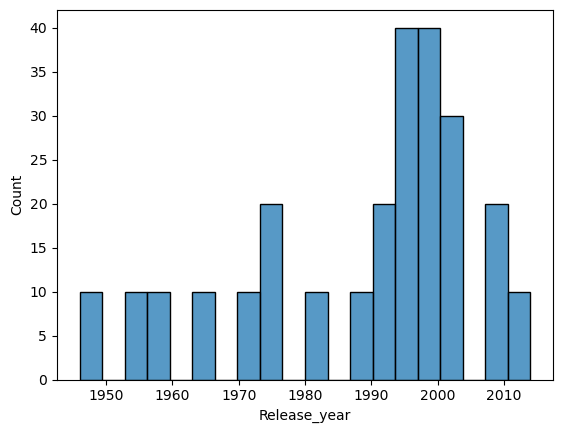

In [102]:
# Visualizing the relation b/w features 
sns.histplot(data=df,bins=20,x="Release_year")

<Axes: xlabel='Rating', ylabel='Count'>

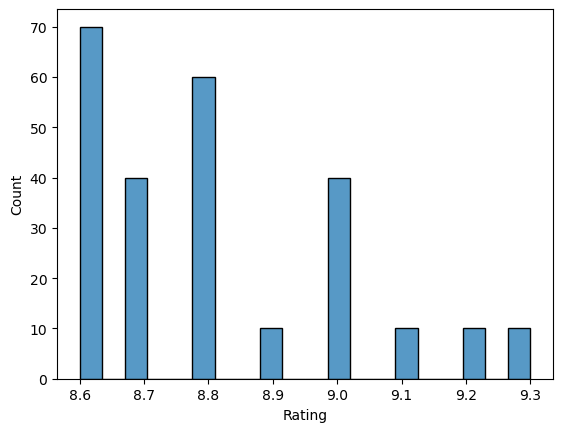

In [103]:
sns.histplot(data=df,bins=20,x="Rating")

<Axes: xlabel='Budget', ylabel='Collection'>

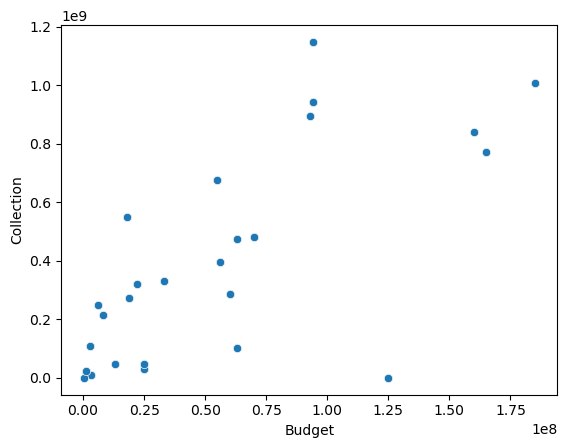

In [106]:
sns.scatterplot(data=df,x="Budget",y="Collection")

<Axes: xlabel='Views', ylabel='Rating'>

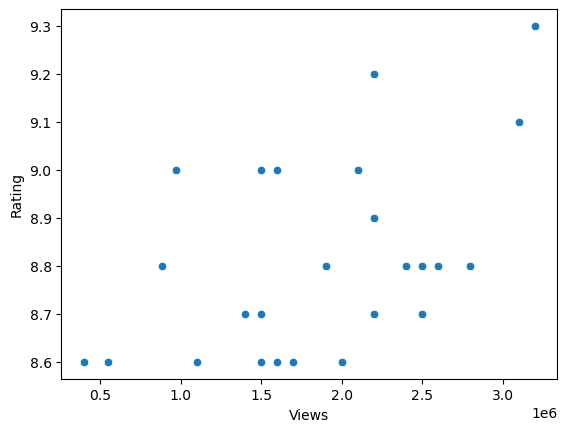

In [107]:
sns.scatterplot(data=df,x="Views",y="Rating")

# Correlarion Heatmap

Text(0.5, 1.0, 'Correlation Heatmap of Movie Dataset')

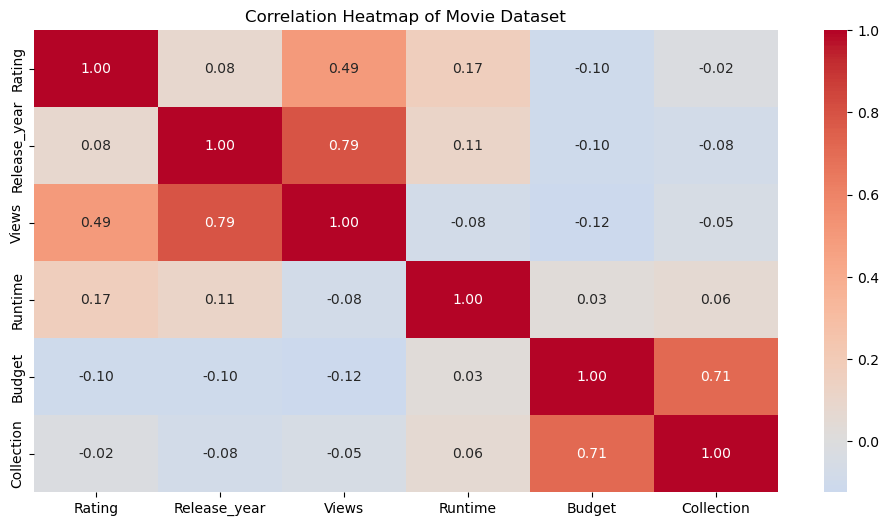

In [119]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(12,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Movie Dataset")

# Building  BaseModel 

In [140]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_squared_error

# convert to log values

In [147]:
df["budget_log"] = np.log1p(df["Budget"])
df["collection_log"] = np.log1p(df["Collection"])
df["views_log"] = np.log1p(df["Views"])

In [148]:
df

,Movie_name,Rating,Release_year,Views,Runtime,Budget,Collection,budget_log,collection_log,views_log
0,The Shawshank Redemption,9.3,1994,3200000.0,142,2.500000e+07,2.933403e+07,17.034386,17.194259,14.978662
1,The Godfather,9.2,1972,2200000.0,175,2.500000e+07,2.933403e+07,17.034386,17.194259,14.603968
2,The Dark Knight,9.1,2008,3100000.0,152,6.000000e+06,2.509264e+08,15.607270,19.340670,14.946913
3,The Godfather Part II,9.0,1974,1500000.0,202,1.850000e+08,1.008477e+09,19.035866,20.731707,14.220976
4,12 Angry Men,9.0,1957,972000.0,96,1.300000e+07,4.820461e+07,16.380460,17.690965,13.787112
...,...,...,...,...,...,...,...,...,...,...
245,It's a Wonderful Life,8.6,1946,551000.0,130,5.613110e+07,3.963153e+08,17.843201,19.797721,13.219492
246,The Silence of the Lambs,8.6,1991,1700000.0,118,5.613110e+07,3.963153e+08,17.843201,19.797721,14.346139
247,Seven Samurai,8.6,1954,399000.0,207,5.613110e+07,3.963153e+08,17.843201,19.797721,12.896719
248,Saving Private Ryan,8.6,1998,1600000.0,169,5.613110e+07,3.963153e+08,17.843201,19.797721,14.285515


In [190]:
x = df.drop(["Collection","Movie_name","Views","Budget","Release_year","collection_log"],axis=1)
y = df["collection_log"]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=42)

In [191]:
x_train

,Rating,Runtime,budget_log,views_log
82,8.9,178,16.906553,14.603968
29,9.0,96,16.380460,13.787112
126,9.2,175,17.034386,14.603968
79,9.0,96,16.380460,13.787112
86,8.8,142,18.358805,14.731802
...,...,...,...,...
106,9.0,195,18.358805,14.285515
14,8.7,124,18.890684,14.220976
92,8.7,169,17.034386,14.731802
179,9.0,96,16.380460,13.787112


In [196]:
y_train

82     19.590563
29     17.690965
126    17.194259
79     17.690965
86     20.665881
         ...    
106    20.861930
14     20.548658
92     17.667291
179    17.690965
102    19.340670
Name: collection_log, Length: 175, dtype: float64

In [197]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Base Model

In [198]:
Linear_model  = LinearRegression()
Linear_model.fit(x_train_scaled,y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [199]:
y_pred = Linear_model.predict(x_test_scaled)
print(f"R^2 Score Test: {r2_score(y_test,y_pred)}")
print(f"MSE:{mean_squared_error(y_test,y_pred)}")

R^2 Score Test: 0.47411599814602534
MSE:3.123625737792575


# Decision tree

In [202]:
from sklearn.tree import DecisionTreeRegressor

In [208]:
Dt_model = DecisionTreeRegressor(
    max_depth = 4,
    min_samples_split=20,
    min_samples_leaf=10,
   random_state=42
)
Dt_model.fit(x_train_scaled,y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,4
,min_samples_split,20
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [210]:

train_pred = Dt_model.predict(x_train_scaled)
test_pred = Dt_model.predict(x_test_scaled)

print("Train R^2:", r2_score(y_train, train_pred))
print("Test R^2:", r2_score(y_test, test_pred))

Train R^2: 0.6300766626376645
Test R^2: 0.588016919895819


In [256]:
# Cross validation

In [257]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [266]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("dt", DecisionTreeRegressor(random_state=42))
])

param_grid = {
    "dt__max_depth": [3, 4, 5, 6],
    "dt__min_samples_split": [20, 30, 40],
    "dt__min_samples_leaf": [10, 15, 20],
}

gridcv = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="r2",
    cv=5,
    n_jobs=-1
)

gridcv.fit(x_train_scaled, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'dt__max_depth': [3, 4, ...], 'dt__min_samples_leaf': [10, 15, ...], 'dt__min_samples_split': [20, 30, ...]}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [267]:
train_pred = gridcv.predict(x_train_scaled)
test_pred = gridcv.predict(x_test_scaled)

print("Train R^2:", r2_score(y_train, train_pred))
print("Test R^2:", r2_score(y_test, test_pred))
print("MSE",mean_squared_error(y_test,test_pred))

Train R^2: 0.6959097153211822
Test R^2: 0.6664365370531987
MSE 1.9812875356059352


# Random Forest

In [268]:
from sklearn.ensemble import RandomForestRegressor

In [269]:
rfr_model = RandomForestRegressor(
    n_estimators = 300,
    max_depth = 4,
    min_samples_split=20,
    min_samples_leaf=10
)
rfr_model.fit(x_train_scaled,y_train)

,n_estimators,300
,criterion,'squared_error'
,max_depth,4
,min_samples_split,20
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [270]:
train_pred = rfr_model.predict(x_train_scaled)
test_pred = rfr_model.predict(x_test_scaled)

print("Train R^2:", r2_score(y_train, train_pred))
print("Test R^2:", r2_score(y_test, test_pred))

Train R^2: 0.6536005210697112
Test R^2: 0.6146987644127238


In [ ]:
# 